In [3]:
# Python
import os
import random

# Pandas
import pandas as pd
from dateutil import tz

# Numpy
import numpy as np
#from numpy.random import RandomState

# SciPy
from scipy.optimize import curve_fit

# Constants
from scipy import constants as Constants

# Matplotlib
import matplotlib.pyplot as plt
font = {'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
import matplotlib.image as pltimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

%matplotlib inline

## Read csv of fitted device positions

In [4]:
pathsDF = pd.read_csv('data/FittedPositions.csv',sep=',')

## define function that gets image and sets size and extent

In [5]:
from skimage import io as skimg_io
def set_fig_properties():
    fig = plt.figure(figsize=(16, 16))
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_xbound(-26.34, 57.36)
    ax.set_ybound(-77.27, 33.13)
    bckgnd = skimg_io.imread('data/map_v2.png')
    ax.imshow(bckgnd, extent=[-26.34, 57.36, 33.13, -77.27])
    ax.set_xlabel("$x [m]$")
    ax.set_ylabel("$y [m]$")
    return fig, ax

## Determine the change in x, y, and $\Delta$ T for consecutive measurements

In [6]:
def shift_col(df_, col_name):
    df_[col_name + '_prev'] = df_[col_name].shift(1)
    return df_

pathsDF = shift_col(pathsDF, 'x')
pathsDF = shift_col(pathsDF, 'y')
pathsDF = shift_col(pathsDF, 'measurementTimestamp')
pathsDF['deltaT'] = (pathsDF['measurementTimestamp'] - pathsDF['measurementTimestamp_prev'])/1000.0

pathsDF['vx'] = (pathsDF['x'] - pathsDF['x_prev'])/(pathsDF['deltaT'])
pathsDF['vy'] = (pathsDF['y'] - pathsDF['y_prev'])/(pathsDF['deltaT'])
pathsDF['v'] = np.sqrt(pow(pathsDF['vx'],2) + pow(pathsDF['vy'],2))


## Make cuts on the velocity between 2 consecutive points (can't be too fast or too slow)

In [7]:
pathsDF_cut = pathsDF[(pathsDF['v'] < 1.5) & (pathsDF['v'] > 0.1) &
                      (pathsDF['deltaT'] != 0)][['x','y','measurementTimestamp','x_prev', 
                                                 'y_prev','deltaT','vx','vy','v']]

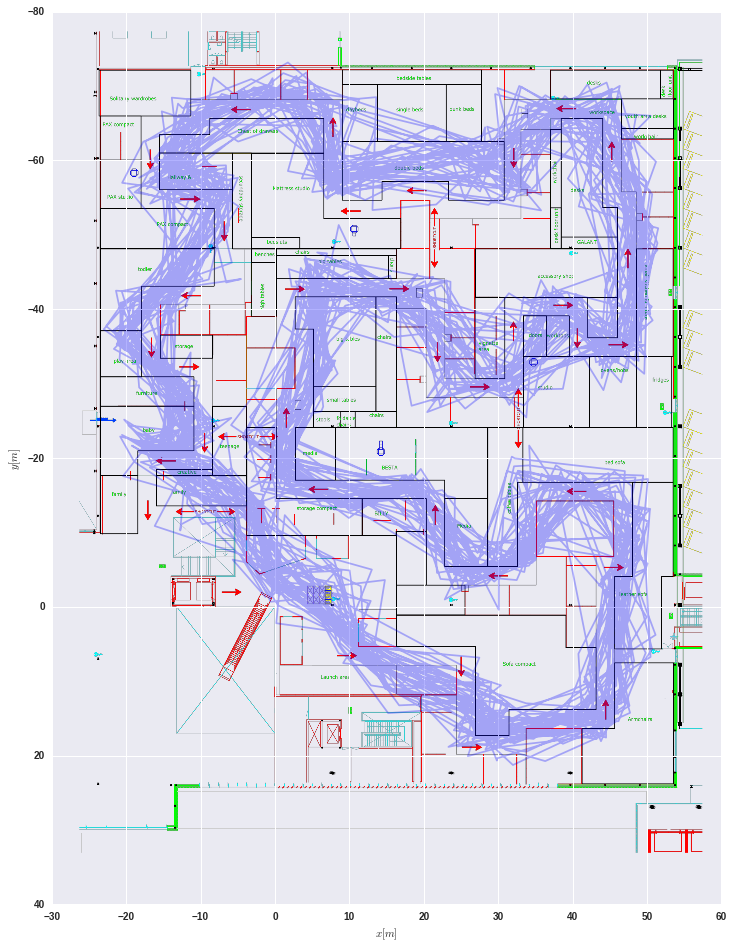

In [8]:
fig, ax = set_fig_properties()
ax.plot(pathsDF_cut['x'], pathsDF_cut['y'], 'b-',alpha=.3)

In [9]:
map_config = {}
xMin = -26.34
xMax = 57.36
yMin = -77.27
yMax = 33.13
map_config['xMin'] = xMin
map_config['yMin'] = yMin
map_config['xMax'] = xMax
map_config['yMax'] = yMax
BIN_SIZE = 2.0
nbinsx = int(np.ceil((xMax - xMin) / BIN_SIZE))
nbinsy = int(np.ceil((yMax - yMin) / BIN_SIZE))


## Calculate velocity vectors and x, y bins

In [10]:
dfpd_seltdvm = pathsDF_cut
dfpd_seltdvm['binx'] = np.floor((dfpd_seltdvm['x_prev'] - xMin) / BIN_SIZE)
dfpd_seltdvm['biny'] = np.floor((dfpd_seltdvm['y_prev'] - yMin) / BIN_SIZE)
dfpd_seltdvm['secs_diff'] = dfpd_seltdvm['deltaT']

In [11]:
def calc_vectors(df):
    """Calculate vectors, the norm and unit vectors for a dataframe that 
    contains colums 'x', 'y', 'x_prev', 'y_prev'.
    """
    df['vec_x_fromprev'] = df['x'] - df['x_prev']
    df['vec_y_fromprev'] = df['y'] - df['y_prev']
    return df

dfpd_seltdvm = calc_vectors(dfpd_seltdvm)

In [12]:
dfpd_seltdvm['binx_center'] = (dfpd_seltdvm['binx'] * BIN_SIZE + BIN_SIZE / 2.0 + map_config['xMin'])
dfpd_seltdvm['biny_center'] = (dfpd_seltdvm['biny'] * BIN_SIZE + BIN_SIZE / 2.0 + map_config['yMin'])
dfpd_seltdvm['vec_x'] = dfpd_seltdvm['vec_x_fromprev'] + dfpd_seltdvm['x_prev'] - dfpd_seltdvm['binx_center']
dfpd_seltdvm['vec_y'] = dfpd_seltdvm['vec_y_fromprev'] + dfpd_seltdvm['y_prev'] - dfpd_seltdvm['biny_center']

In [13]:
def compute_norm_and_unit_vectors(df):
    df['norm'] = np.sqrt(df['vec_x']**2 + df['vec_y']**2)
    df['vec_x_unit'] = df['vec_x'] / df['norm']
    df['vec_y_unit'] = df['vec_y'] / df['norm']
    return df
dfpd_seltdvm = compute_norm_and_unit_vectors(dfpd_seltdvm)

In [14]:
# Toggle between regular vectors or unit vectors by commenting the appropriate lines: 
#vec_x = 'vec_x'
#vec_y = 'vec_y'
vec_x = 'vec_x_unit'
vec_y = 'vec_y_unit'

def calc_angle(row):
    row['angle'] = np.arctan2(row[vec_y], row[vec_x])
    if row[vec_y] < 0:
        row['angle'] += np.pi * 2
    return row

gby = dfpd_seltdvm.groupby(['binx', 'biny'])
dfres = gby[vec_x, vec_y].sum()
dfres = dfres.apply(calc_angle, axis=1)
dfres['v'] = gby['v'].mean()  
# Might be able to use the norm as a way to express strength/magnitude of the direction:
dfres['norm'] = np.sqrt(dfres[vec_x]**2 + dfres[vec_y]**2)
# Counts are also good to know, we might not want to include vectors that were made using a small amount of fits:
dfres['cnt'] = gby[vec_x].count()
dfres.head(5)

vec_x_unit  vec_y_unit     angle         v      norm  cnt
binx biny                                                           
1.0  19.0    0.791176    0.611589  0.658067  1.302768  1.000000    1
     38.0    0.808117   -0.589022  5.653337  0.104433  1.000000    1
2.0  7.0     0.846962    0.531654  0.560552  1.202939  1.000000    1
     9.0     0.997783    0.066547  0.066596  1.411632  1.000000    1
     17.0    0.547583    1.918484  1.292764  1.332008  1.995101    2

In [15]:
dfres = dfres[dfres.cnt > 1]

## Finally plot the flow using quiver with equal length vectors

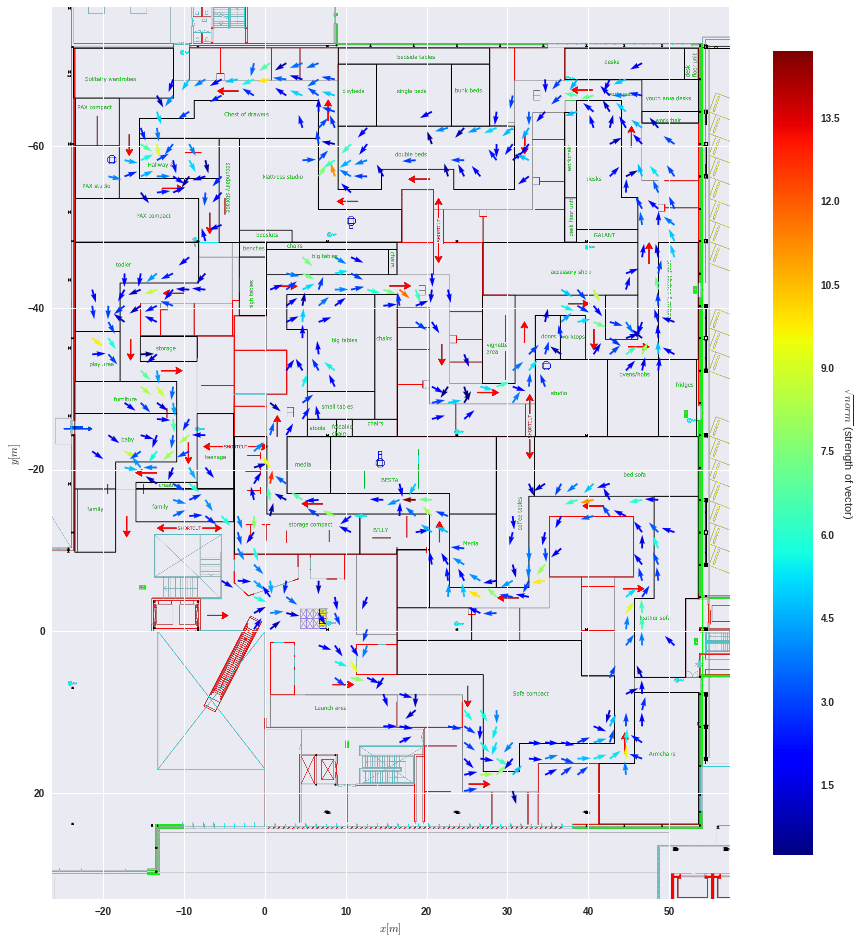

In [16]:
def plot_quiver(arrow_length_strength=False):
    fig, ax = set_fig_properties()

    if arrow_length_strength:
        # Divide by count to normalize (vectors were only added up before):
        U = dfres[vec_x] / dfres.cnt
        V = (dfres[vec_y] / dfres.cnt) * -1, # Have to invert this manually
    else:
        U = np.cos(dfres.angle)
        V = np.sin(dfres.angle) * -1, # Have to invert this manually

    quiv = ax.quiver(
        dfres.index.get_level_values('binx') * BIN_SIZE + BIN_SIZE/2.0 + map_config['xMin'],
        dfres.index.get_level_values('biny') * BIN_SIZE + BIN_SIZE/2.0 + map_config['yMin'],
        U,
        V,
        # Values for the colorbar:
        dfres.norm, 
        cmap= cm.jet, #cm.BuPu,
       # headlength=4,
        scale=50,        
    )        

 
    cbar = fig.colorbar(quiv, fraction=.045)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel("$\sqrt{norm}$ (strength of vector)", rotation=270)

plot_quiver(arrow_length_strength=False)